nodes:  50 links  69


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: Min Fitness 4553.170667021992
Generation 0: Min Fitness 3945.6294682256125
Generation 0: Min Fitness inf
Generation 0: Min Fitness 4059.7125732796085
Generation 1: Min Fitness 3794.070094514318
Generation 1: Min Fitness 3945.6294682256125
Generation 1: Min Fitness 4439.260369674768
Generation 2: Min Fitness 3681.663555728089
Generation 2: Min Fitness 3738.831448155772
Generation 1: Min Fitness 4059.7125732796085
Generation 2: Min Fitness 4251.250801973187
Generation 3: Min Fitness 3738.831448155772
Generation 3: Min Fitness 3681.663555728089
Generation 2: Min Fitness 3840.054369434604
Generation 3: Min Fitness 4056.472494316675
Generation 4: Min Fitness 3681.663555728089
Generation 4: Min Fitness 3706.5239141046495
Generation 5: Min Fitness 3681.663555728089
Generation 3: Min Fitness 3840.054369434604
Generation 4: Min Fitness 4054.3911266062078
Generation 6: Min Fitness 3536.5919453206666
Generation 5: Min Fitness 3510.591190710091
Generation 7: Min Fitness 3464.29273751

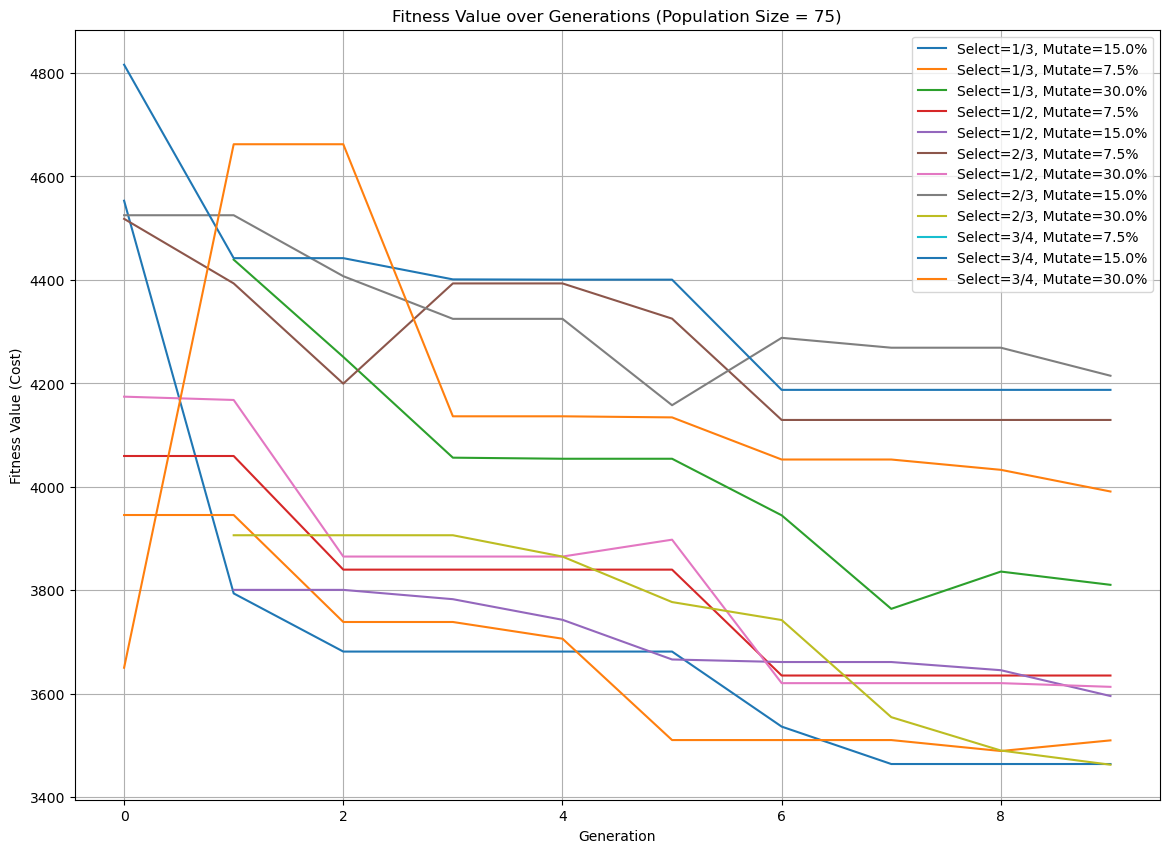

Generation 0: Min Fitness 3913.97782997007
Generation 0: Min Fitness inf
Generation 0: Min Fitness 4183.539279648012
Generation 0: Min Fitness 3787.200008427991
Generation 1: Min Fitness 3924.842965938421
Generation 1: Min Fitness inf
Generation 1: Min Fitness 4183.539279648012
Generation 2: Min Fitness 3924.842965938421
Generation 2: Min Fitness 4183.539279648012
Generation 1: Min Fitness 3787.200008427991
Generation 2: Min Fitness inf
Generation 3: Min Fitness 3892.5814867439894
Generation 3: Min Fitness 3924.842965938421
Generation 2: Min Fitness 3555.5640242389954
Generation 3: Min Fitness inf
Generation 4: Min Fitness 3892.5814867439894
Generation 4: Min Fitness 3851.885377194358
Generation 4: Min Fitness 3948.267448441504
Generation 5: Min Fitness 3892.5814867439894
Generation 5: Min Fitness 3562.9681549921756
Generation 3: Min Fitness 3518.5590375046736
Generation 6: Min Fitness 3789.5949913078216
Generation 6: Min Fitness 3562.9681549921756
Generation 5: Min Fitness inf
Generat

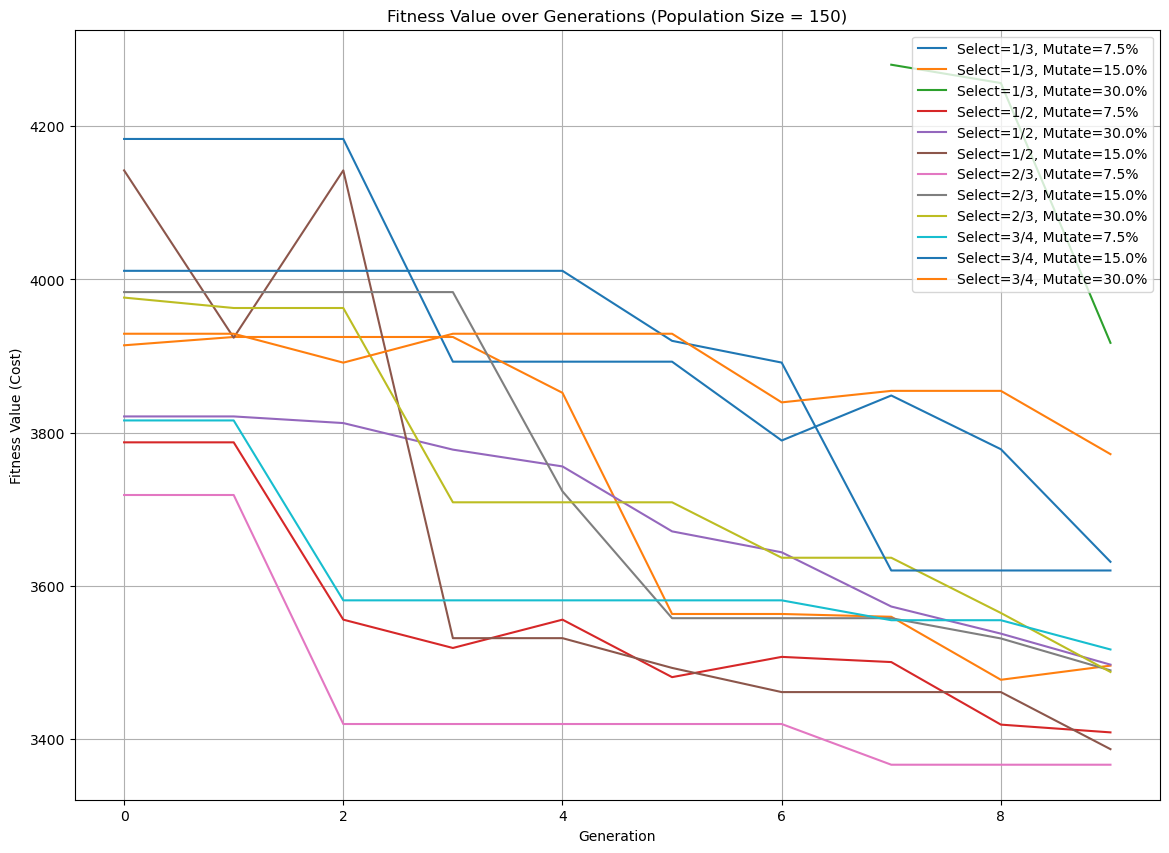

Generation 0: Min Fitness 4007.1604122504896
Generation 0: Min Fitness 3629.6466178375476
Generation 0: Min Fitness 3591.9758869824464
Generation 1: Min Fitness 4168.381567365363
Generation 0: Min Fitness 3710.0873075750737
Generation 1: Min Fitness 3451.32617926051
Generation 1: Min Fitness 3629.6466178375476
Generation 2: Min Fitness 3882.4920531178786
Generation 2: Min Fitness 3629.6466178375476
Generation 2: Min Fitness 3451.32617926051
Generation 3: Min Fitness 3882.4920531178786
Generation 1: Min Fitness 3710.0873075750737
Generation 4: Min Fitness 3845.8320602668823
Generation 3: Min Fitness 3401.412205027055
Generation 3: Min Fitness 3451.32617926051
Generation 5: Min Fitness 3845.8320602668823
Generation 2: Min Fitness 3710.0873075750737
Generation 4: Min Fitness 3401.412205027055
Generation 4: Min Fitness 3451.32617926051
Generation 6: Min Fitness 3845.8320602668823
Generation 5: Min Fitness 3362.419641794075
Generation 3: Min Fitness 3591.228201866581
Generation 7: Min Fitne

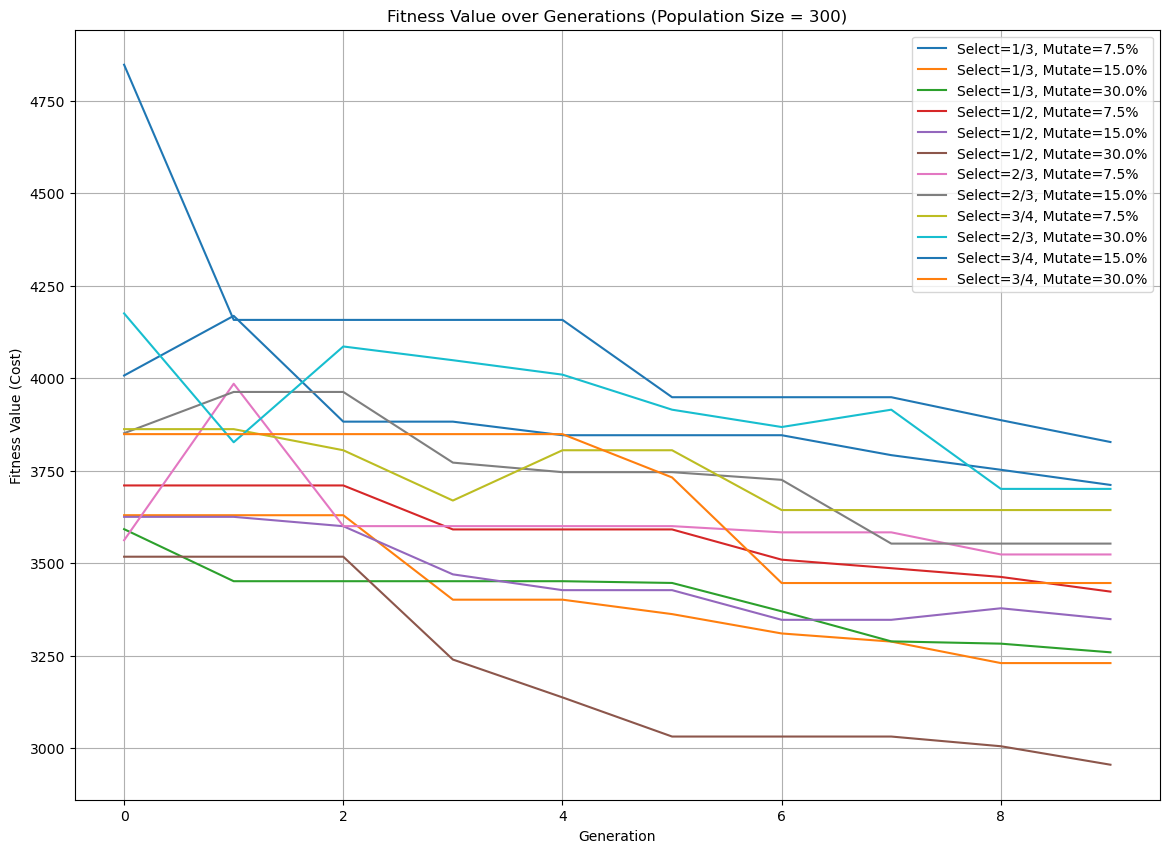

In [2]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction

# 读取图和位置信息
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程
def main(population_size, selection_ratio, mutpb):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 10
    cxpb = 0.5  # 交叉概率

    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

# 配置参数
population_sizes = [75, 150, 300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 逐个运行每个种群大小的12种情况
for population_size in population_sizes:
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb): (selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        logbooks = {}
        labels = {}

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, _ = future.result()
                logbooks[(selection_ratio, mutpb)] = logbook
                ratio_fraction = Fraction(selection_ratio).limit_denominator()
                labels[(selection_ratio, mutpb)] = f'Select={ratio_fraction}, Mutate={mutpb*100}%'
            except Exception as ex:
                print(f'Error with population_size={population_size}, selection_ratio={selection_ratio}, mutpb={mutpb}: {ex}')

    # 绘制图表
    plt.figure(figsize=(14, 10))
    for (selection_ratio, mutpb), logbook in logbooks.items():
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, label=labels[(selection_ratio, mutpb)])
    
    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_36_TPE/fitness_over_generations_population_{population_size}.png")
    plt.show()


In [14]:
from tqdm.notebook import tqdm
import time

for i in tqdm(range(100), desc="Test Progress"):
    time.sleep(0.1)


KeyboardInterrupt: 

nodes:  50 links  69


Population=75:   0%|          | 0/120 [00:00<?, ?it/s]

Population=150:   0%|          | 0/120 [00:00<?, ?it/s]

Population=300:   0%|          | 0/120 [00:00<?, ?it/s]

/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


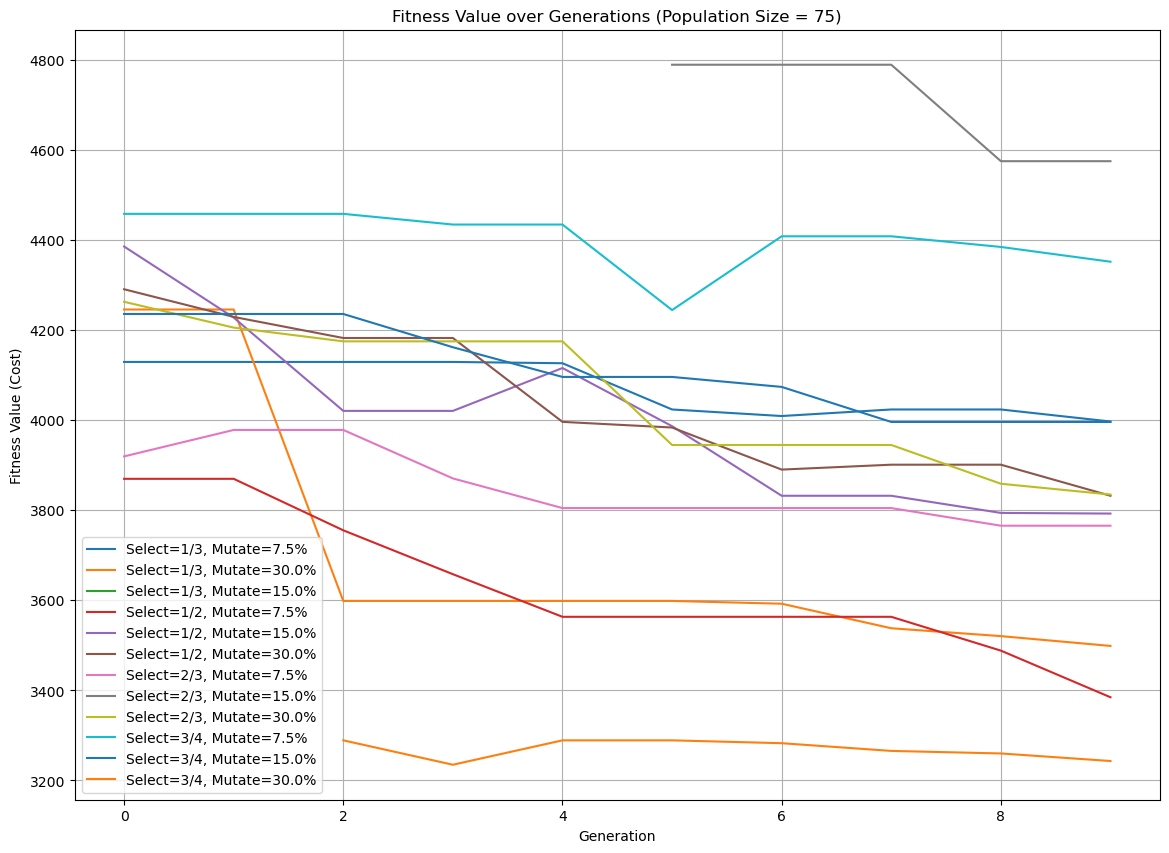

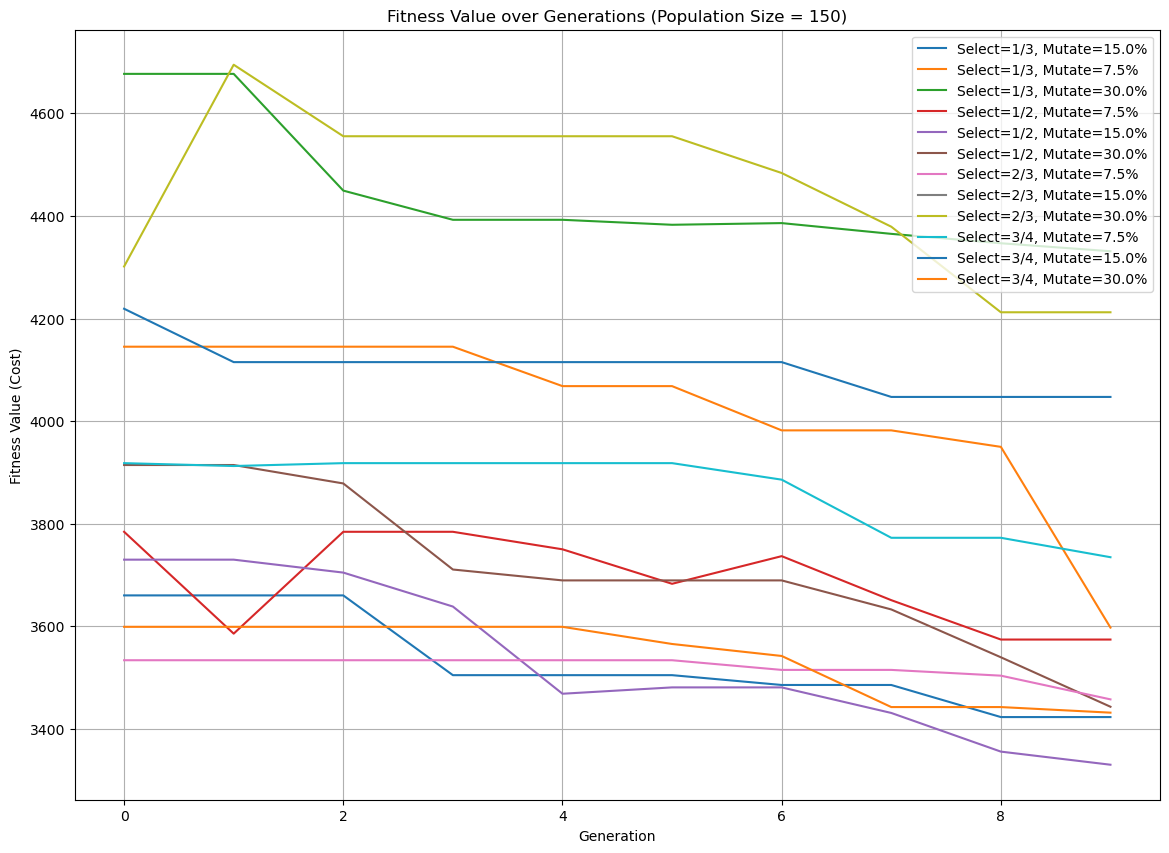

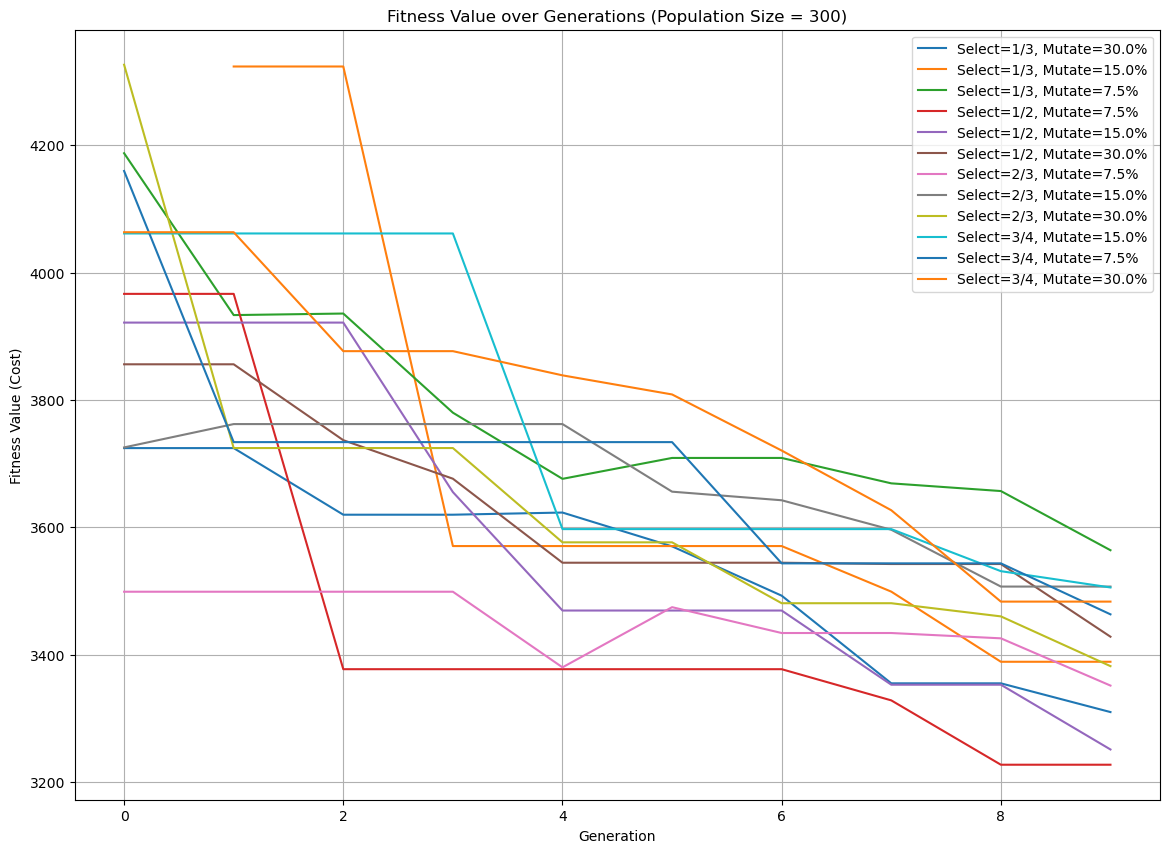

In [1]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm

# 读取图和位置信息
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, pbar):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 10  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

# 配置参数
population_sizes = [75, 150, 300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 10, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况
for population_size in population_sizes:
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, progress_bars[population_size]): (selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        logbooks = {}
        labels = {}

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, _ = future.result()
                logbooks[(selection_ratio, mutpb)] = logbook
                ratio_fraction = Fraction(selection_ratio).limit_denominator()
                labels[(selection_ratio, mutpb)] = f'Select={ratio_fraction}, Mutate={mutpb*100}%'
            except Exception as ex:
                print(f'Error with population_size={population_size}, selection_ratio={selection_ratio}, mutpb={mutpb}: {ex}')

    # 绘制图表
    plt.figure(figsize=(14, 10))
    for (selection_ratio, mutpb), logbook in logbooks.items():
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, label=labels[(selection_ratio, mutpb)])
    
    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_36_TPE/20fitness_over_generations_population_{population_size}.png")
    plt.show()

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()


nodes:  37 links  46


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Population=75:   0%|          | 0/12000 [00:00<?, ?it/s]

Population=150:   0%|          | 0/12000 [00:00<?, ?it/s]

Population=300:   0%|          | 0/12000 [00:00<?, ?it/s]

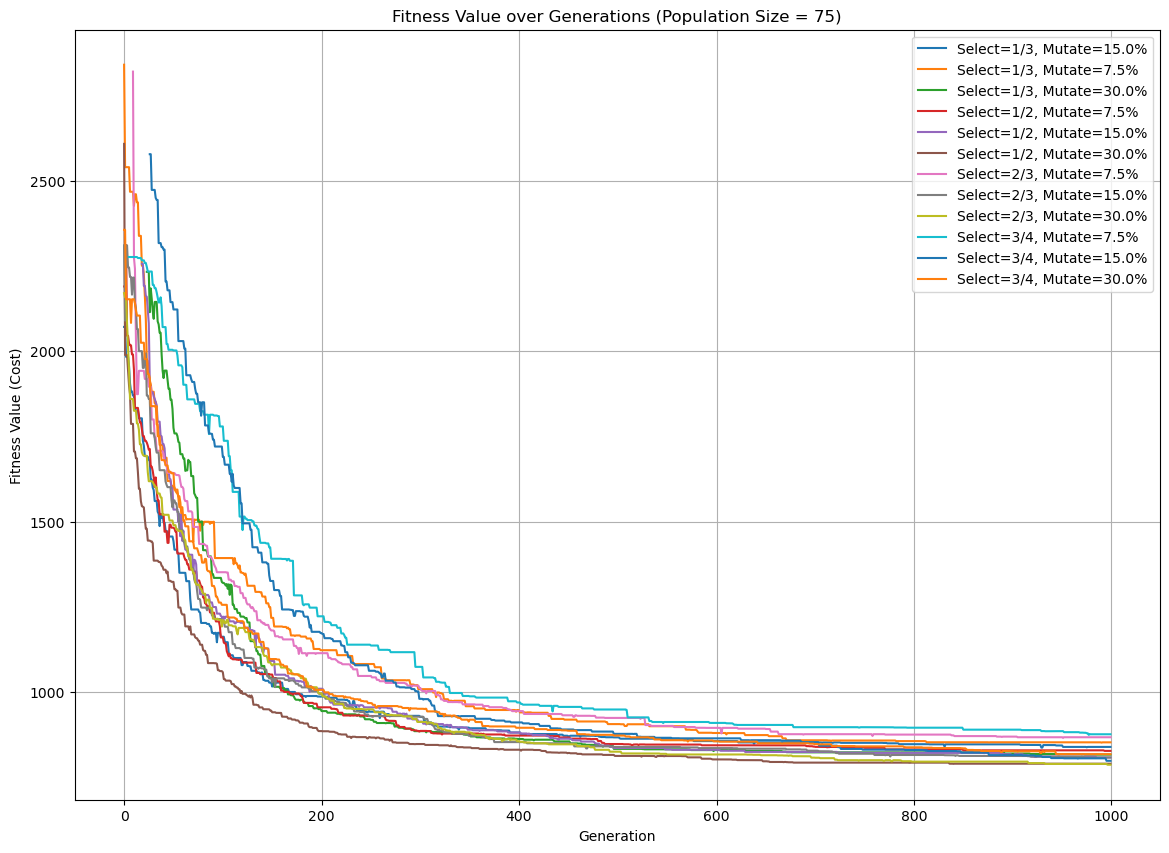

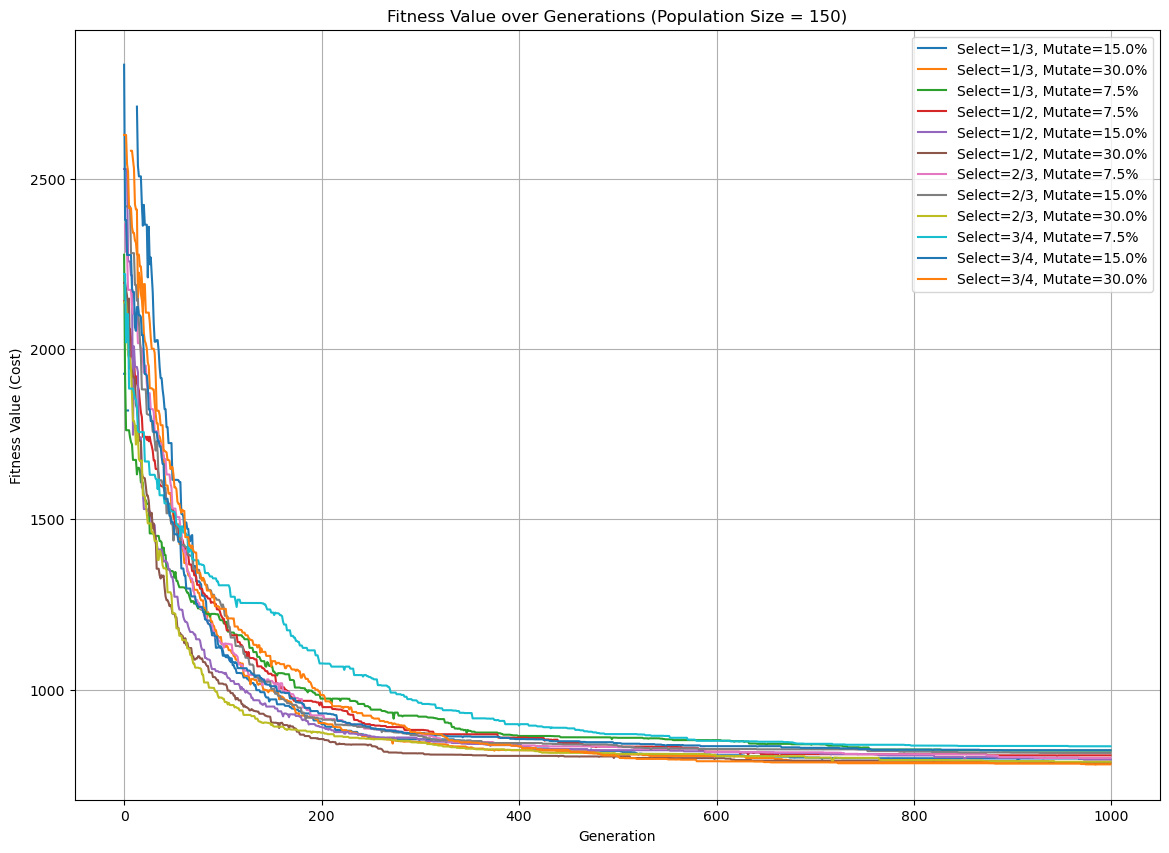

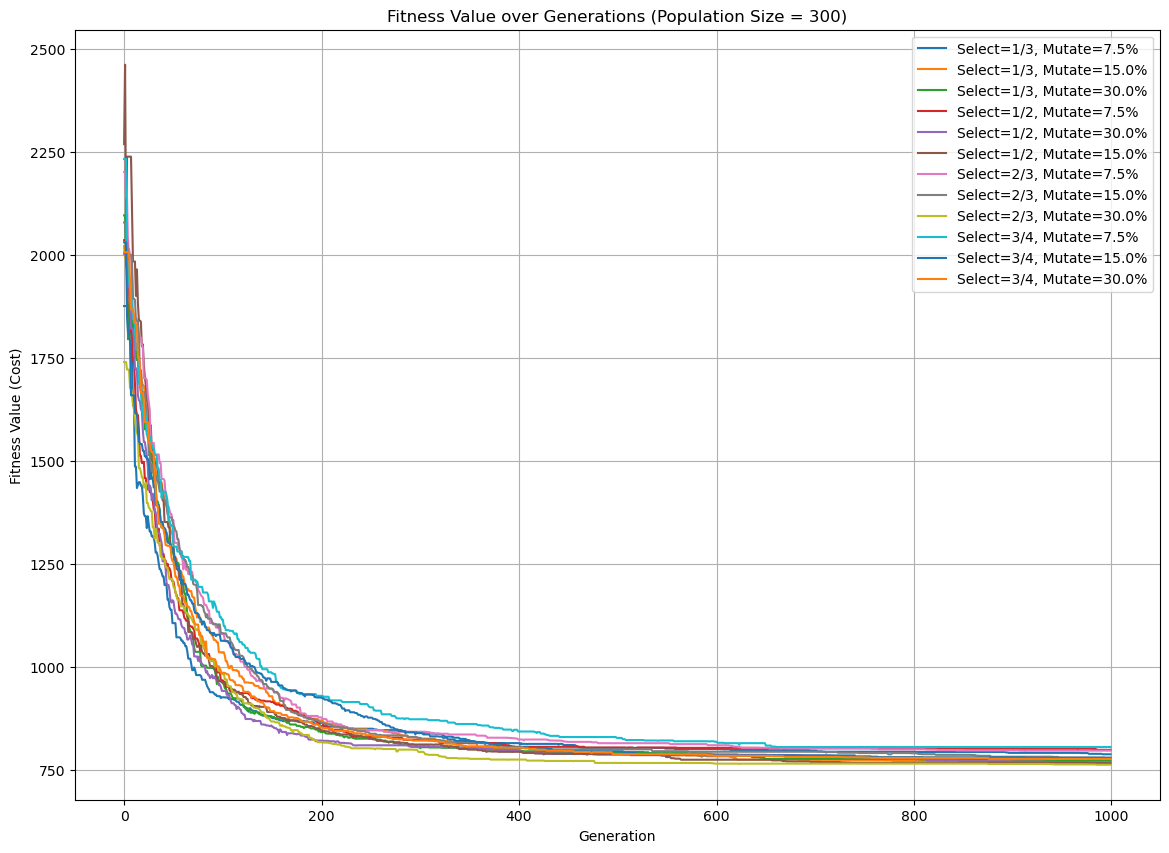

In [2]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm

# 读取图和位置信息
filename1 = "cost266"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程
def main(population_size, selection_ratio, mutpb, pbar):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1000  # 设定总迭代次数
    cxpb = 0.5  # 交叉概率

    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

        # 更新进度条
        pbar.update(1)

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof


# 配置参数
population_sizes = [75, 150, 300]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 初始化进度条
progress_bars = {
    pop_size: tqdm(total=12 * 1000, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 逐个运行每个种群大小的12种情况
for population_size in population_sizes:
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, progress_bars[population_size]): (
            selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        logbooks = {}
        labels = {}

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                logbook, _ = future.result()
                logbooks[(selection_ratio, mutpb)] = logbook
                ratio_fraction = Fraction(selection_ratio).limit_denominator()
                labels[(selection_ratio, mutpb)] = f'Select={ratio_fraction}, Mutate={mutpb * 100}%'
            except Exception as ex:
                print(
                    f'Error with population_size={population_size}, selection_ratio={selection_ratio}, mutpb={mutpb}: {ex}')

    # 绘制图表
    plt.figure(figsize=(14, 10))
    for (selection_ratio, mutpb), logbook in logbooks.items():
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, label=labels[(selection_ratio, mutpb)])

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_36_TPE/{filename1}_fitness_over_generations_population_{population_size}.png")
    plt.show()

# 完成后关闭所有进度条
for pbar in progress_bars.values():
    pbar.close()
